In [ ]:
import sys
import joblib
import os
import scipy.io as sio
import numpy as np

import torch
import cmocean as cm

In [2]:
# Adjust the path to your project root directory where 'models' folder is located
project_root = os.path.abspath('../../../')  # or the relative path to your root from the notebook folder

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.models.cnn import CNN_AE
from src.inputs import GaussianInputs
from src.optimizer import GPOptimizer, DeepGPOptimizer
from src.utils import *

In [6]:
project = 'kolmogorov'

In [3]:
L1, L2 = 2*np.pi, 2*np.pi
n1, n2 = 64, 64

grid_x = np.linspace(0,L1-L1/n1,n1)
grid_y = np.linspace(0,L2-L2/n2,n2)

grid_x, grid_y = np.meshgrid(grid_x, grid_y)

Kx = np.concatenate([np.arange(0, n1//2), np.arange(-n1//2, 0)]) * (2 * np.pi / L1)
Ky = np.concatenate([np.arange(0, n2//2), np.arange(-n2//2, 0)]) * (2 * np.pi / L2)

kx, ky = np.meshgrid(Kx,Ky)

dt_sim = 0.5
T_sim = 10000
nt = int(T_sim/dt_sim)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
u = np.load(f'{project_root}/data/{project}/u1.npy')
v = np.load(f'{project_root}/data/{project}/u2.npy')
w = np.load(f'{project_root}/data/{project}/vorticity.npy')

In [8]:
tstep = 9407
u_true = u[tstep, :, :]
v_true = v[tstep, :, :]
w_true = w[tstep, :, :]

base_dir = f'{project_root}/results/{project}/bo/constant_flow/{tstep}'

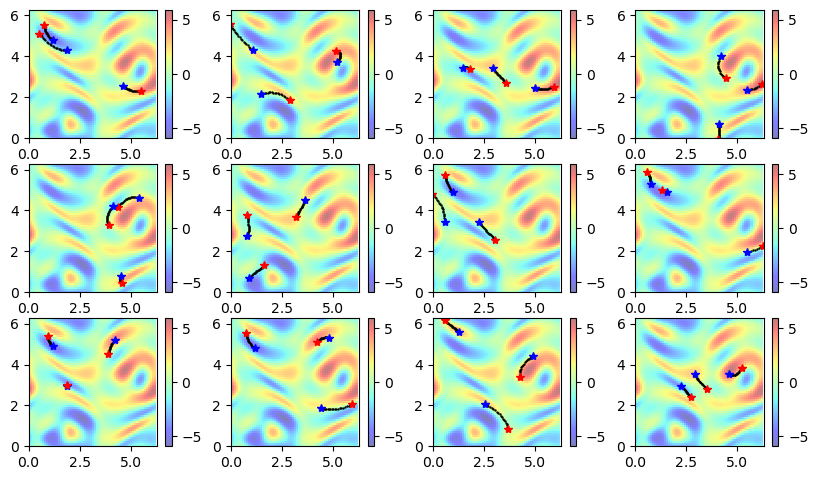

In [25]:
dt = 0.05
T = 1
dts = [dt for _ in range(int(T / dt))]

num_traj = 3
num_exp = 1000

exp_vals = list(np.arange(num_exp))
exp_vals_copy = exp_vals.copy()

np.random.seed(2)
idx0 = {}
for exp_i in exp_vals:
    idx0[exp_i] = {}
    idx0[exp_i]['x0'], idx0[exp_i]['y0'] = [], []
    for traj_i in range(num_traj):
        x0_idx = np.random.randint(4, n1-5)
        y0_idx = np.random.randint(4, n2-5)

        idx0[exp_i]['x0'].append(x0_idx)
        idx0[exp_i]['y0'].append(y0_idx)

trajectories = {}
for exp_i in exp_vals:
    trajectories[exp_i] = {}
    exp_str = f'exp_x0_{"_".join(map(str, idx0[exp_i]["x0"]))}_y0_{"_".join(map(str, idx0[exp_i]["y0"]))}'
    exp_dir = os.path.join(base_dir, exp_str)
    for traj_i in range(num_traj):
        traj_path = os.path.join(exp_dir, f'traj_{traj_i}.npy')     
        trajectories[exp_i][traj_i] = np.load(traj_path)

plt.figure(figsize=(10,int(np.ceil(num_exp/4))*2))

for exp_i in range(12):        
    ax = plt.subplot(int(np.ceil(num_exp/4)), 4, exp_i+1)
    c = plot_trajectories(ax, w_true, grid_x, grid_y, trajectories[exp_i], 0, L1, 0, L2, cmap='jet')
    plt.colorbar(c)

In [11]:
latent_dim = 20
ae = CNN_AE(latent_dim=latent_dim)

ae.load_state_dict(torch.load(f'{project_root}/src/models/checkpoints/{project}/cnn_{latent_dim}_model.pth'))
ae.to(device)
D = ae.decode

data, ae_scaler = transform_data_for_AE(u,v)
latent_space = get_latent_space(ae, data)

latent_distribution = gaussian_kde(latent_space)

In [12]:
acquisition_function = 'LCB'

deep = True

if latent_dim == 50:
    deep = True
    n_iter = 75
else:
    n_iter = 100

optimizers = {}
for exp_i in exp_vals:
    if deep:
        optimizers[exp_i] =  DeepGPOptimizer(trajectories[exp_i], dts, trajectory_cost_function, D, latent_distribution, grid_x, grid_y, ae_scaler, device, acquisition_function, n_init=0, train_init=False)
    else:
        optimizers[exp_i] = GPOptimizer(trajectories[exp_i], dts, trajectory_cost_function, D, latent_distribution, grid_x, grid_y, ae_scaler, device, acquisition_function, n_init=0, train_init=False)

In [26]:
load_data = True
if deep:
    tag = ''
else:
    tag = 'GP_'

if load_data:
    base_path = f'{project_root}/results/{project}/bo/constant_flow/{tstep}'
    subfolder = f'{tag}{acquisition_function}_{latent_dim}'

    for exp_i in exp_vals:
        exp_str = f'exp_x0_{"_".join(map(str, idx0[exp_i]["x0"]))}_y0_{"_".join(map(str, idx0[exp_i]["y0"]))}'
        exp_path = os.path.join(base_path, exp_str, subfolder)

        if not os.path.exists(exp_path):
            print(f'Warning: {exp_path} does not exist. Skipping...')
            exp_vals_copy.remove(exp_i)
            continue

        optimizer = optimizers[exp_i]
        optimizer.X = np.load(os.path.join(exp_path, 'X.npy'))
        optimizer.Y = np.load(os.path.join(exp_path, 'Y.npy'))

        optimizer.scaler_gp_x = joblib.load(os.path.join(exp_path, 'scaler_gp_x.joblib'))
        optimizer.scaler_gp_y = joblib.load(os.path.join(exp_path, 'scaler_gp_y.joblib'))

exp_vals = exp_vals_copy

In [27]:
z_opt, u_opt, v_opt, w_opt, traj_opt = [], [], [], [], []
u_err, v_err, w_err = [], [], []
for exp_i in exp_vals:
    optimizer = optimizers[exp_i]

    k=1
    
    if k == 1:
        z_i, u_i, v_i, traj_i = optimizer.get_optimal()
    else:
        _, _, _, traj_i = optimizer.get_top_k(k=k)
        u_i, v_i = optimizer.get_top_k_mean(k=k)

    w_i = vort(u_i, v_i, kx, ky)
    # z_opt.append(z_i)
    u_opt.append(u_i)
    v_opt.append(v_i)
    w_opt.append(w_i)
    traj_opt.append(traj_i)

    u_err.append(u_true - u_i)
    v_err.append(v_true - v_i)
    w_err.append(w_true - w_i)



 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning:Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/envs/bld/conda-bld/pytorch-select_1719512383855/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)


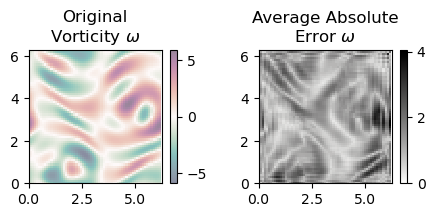

In [39]:
# Compute the average of absolute errors across all samples
avg_w_err = np.mean([np.abs(err) for err in w_err], axis=0)

# Plot the average errors
plt.subplots(figsize=(4.5, 2))
plt.subplot(1, 2, 1)
plt.pcolormesh(grid_x, grid_y, w_true, cmap=cm.cm.curl, alpha=0.5)
plt.xlim(0, L1)
plt.ylim(0, L2)
plt.colorbar()
plt.gca().set_aspect('equal')
plt.title('Original\nVorticity $\omega$', fontsize=12)

plt.subplot(1, 2, 2)
plt.pcolormesh(grid_x, grid_y, avg_w_err, cmap=cm.cm.gray_r, vmin=0)
plt.xlim(0, L1)
plt.ylim(0, L2)
plt.colorbar()
plt.gca().set_aspect('equal')
# plt.title(f'Average Absolute\nError $\omega$ (RMSE = {np.sqrt(np.mean(avg_w_err**2)):.2f})', fontsize=12)
plt.title(f'Average Absolute\nError $\omega$', fontsize=12)


plt.tight_layout()
plt.savefig(f'{project_root}/figures/{project}/bo/constant_flow_{tstep}_average_error_{num_exp}_{acquisition_function}_{latent_dim}.png', dpi=300, bbox_inches='tight')
plt.show()

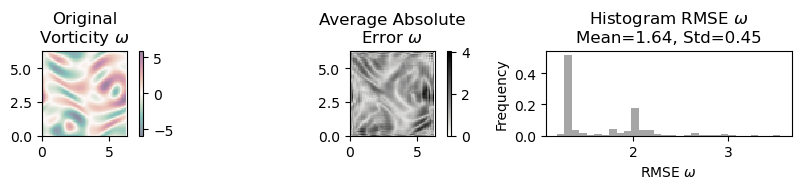

In [ ]:
# Compute the average of absolute errors across all samples
avg_w_err = np.mean([np.abs(err) for err in w_err], axis=0)

# Plot the average errors
plt.subplots(figsize=(9, 2))
plt.subplot(1, 3, 1)
plt.pcolormesh(grid_x, grid_y, w_true, cmap=cm.cm.curl, alpha=0.5)
plt.xlim(0, L1)
plt.ylim(0, L2)
plt.colorbar()
plt.gca().set_aspect('equal')
plt.title('Original\nVorticity $\omega$', fontsize=12)

plt.subplot(1, 3, 2)
plt.pcolormesh(grid_x, grid_y, avg_w_err, cmap=cm.cm.gray_r, vmin=0)
plt.xlim(0, L1)
plt.ylim(0, L2)
plt.colorbar()
plt.gca().set_aspect('equal')
# plt.title(f'Average Absolute\nError $\omega$ (RMSE = {np.sqrt(np.mean(avg_w_err**2)):.2f})', fontsize=12)
plt.title(f'Average Absolute\nError $\omega$', fontsize=12)

plt.subplot(1, 3, 3)
rmse_w = [np.sqrt(np.mean(err**2)) for err in w_err]
plt.hist(rmse_w, bins=30, color='gray', alpha=0.7, weights=np.ones_like(rmse_w) / len(rmse_w))
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.title(f'Histogram RMSE $\omega$\nMean={np.mean(rmse_w):.2f}, Std={np.std(rmse_w):.2f}', fontsize=12)

plt.tight_layout()
plt.savefig(f'{project_root}/figures/{project}/bo/constant_flow_{tstep}_average_error_{num_exp}_{acquisition_function}_{latent_dim}_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

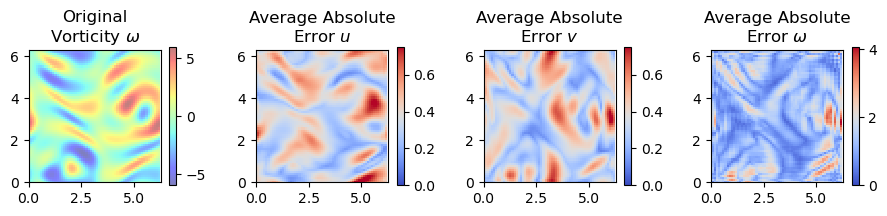

In [ ]:
# # Compute the average of absolute errors across all samples
# avg_u_err = np.mean([np.abs(err) for err in u_err], axis=0)
# avg_v_err = np.mean([np.abs(err) for err in v_err], axis=0)
# avg_w_err = np.mean([np.abs(err) for err in w_err], axis=0)

# # Plot the average errors
# plt.subplots(figsize=(9, 2))
# plt.subplot(1, 4, 1)
# plt.pcolormesh(grid_x, grid_y, w_true, cmap='jet', alpha=0.5)
# plt.xlim(0, L1)
# plt.ylim(0, L2)
# plt.colorbar()
# plt.gca().set_aspect('equal')
# plt.title('Original\nVorticity $\omega$', fontsize=12)

# plt.subplot(1, 4, 2)
# plt.pcolormesh(grid_x, grid_y, avg_u_err, cmap='coolwarm', vmin=0, vmax=0.75)
# plt.colorbar()
# plt.xlim(0, L1)
# plt.ylim(0, L2)
# plt.gca().set_aspect('equal')
# plt.title('Average Absolute\nError $u$', fontsize=12)

# plt.subplot(1, 4, 3)
# plt.pcolormesh(grid_x, grid_y, avg_v_err, cmap='coolwarm', vmin=0, vmax=0.75)
# plt.xlim(0, L1)
# plt.ylim(0, L2)
# plt.colorbar()
# plt.gca().set_aspect('equal')
# plt.title('Average Absolute\nError $v$', fontsize=12)

# plt.subplot(1, 4, 4)
# plt.pcolormesh(grid_x, grid_y, avg_w_err, cmap='coolwarm', vmin=0)
# plt.xlim(0, L1)
# plt.ylim(0, L2)
# plt.colorbar()
# plt.gca().set_aspect('equal')
# plt.title('Average Absolute\nError $\omega$', fontsize=12)

# plt.tight_layout()
# # plt.savefig(f'Kolmogorov_Figures/constant_flow_{tstep}_average_error_{num_exp}_{acquisition_function}_{latent_dim}.png', dpi=300, bbox_inches='tight')
# plt.show()

RMSE u: Mean = 0.450, Std = 0.183
RMSE v: Mean = 0.436, Std = 0.208
RMSE \omega: Mean = 1.642, Std = 0.448


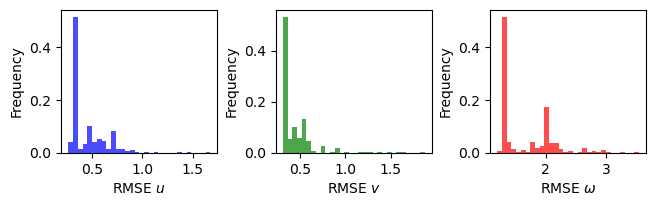

In [ ]:
# # Calculate MSE for u, v, and w
# errors = {'u': u_err, 'v': v_err, '\omega': w_err}
# rmse = {key: [np.sqrt(np.mean(err**2)) for err in value] for key, value in errors.items()}

# # Plot histograms
# plt.figure(figsize=(6.5, 2))
# colors = {'u': 'blue', 'v': 'green', '\omega': 'red'}

# for i, (key, mse_values) in enumerate(rmse.items(), 1):
#     plt.subplot(1, 3, i)
#     weights = np.ones_like(mse_values) / len(mse_values)
#     plt.hist(mse_values, bins=30, color=colors[key], alpha=0.7, weights=weights)
#     # plt.title(f'Histogram of\nRMSE for ${key}$')
#     # plt.title(f'${key}$')
#     plt.xlabel(f'RMSE ${key}$')
#     plt.ylabel('Frequency')

#     print(f'RMSE {key}: Mean = {np.mean(mse_values):.3f}, Std = {np.std(mse_values):.3f}')

# plt.tight_layout(pad=0.5)
# # plt.savefig(f'Kolmogorov_Figures/constant_flow_{tstep}_error_histogram_{num_exp}_{acquisition_function}_{latent_dim}.png', dpi=300, bbox_inches='tight')

# plt.show()
